In [21]:
import os
import numpy as np
import pandas as pd
import librosa
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary

In [22]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


In [23]:
# data_dir="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small"
# file_path="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small/000/000002.mp3"
train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_combined.csv'
# train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_wav2vec.csv'
torch.manual_seed(42)

data_df=pd.read_csv(train_path, index_col=0)
# data_df=pd.read_csv(train_path)


In [24]:


# Assuming data_df is your DataFrame containing features and genre labels
X = StandardScaler().fit_transform(data_df.drop('genre', axis=1))
genres = data_df['genre'].unique()
binary_labels = {genre: (data_df['genre'] == genre).astype(int) for genre in genres}


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [26]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
def create_loaders(X, y, batch_size=128):
    """ Create DataLoaders for training and testing datasets """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Convert to tensors and move to the device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Creating datasets and loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader



In [27]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),

            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128,out_features=output_dim)

        )
        
    def forward(self, x):
        return self.layers(x)


In [28]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, device, epochs=100,lr=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracies = []  # List to store accuracy for each epoch
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        total = correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)  # Store accuracy for this epoch

        print(f'Epoch {epoch+1}: Accuracy: {accuracy}%')

    # Plotting the accuracies
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, epochs+1), accuracies, marker='o', linestyle='-')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.xticks(range(1, epochs+1))  # Ensure x-axis labels match epoch numbers
    plt.yticks(range(0, 101, 10))  # Setting y-axis labels from 0 to 100% with steps of 10%
    plt.show()

    return max(accuracies)  # Return the highest accuracy reached


Epoch 1: Accuracy: 66.98624426844519%
Epoch 2: Accuracy: 76.32346811171321%
Epoch 3: Accuracy: 86.53605669028762%
Epoch 4: Accuracy: 86.32763651521468%
Epoch 5: Accuracy: 87.86994581075449%
Epoch 6: Accuracy: 88.45352230095874%
Epoch 7: Accuracy: 88.32847019591496%
Epoch 8: Accuracy: 89.57899124635264%
Epoch 9: Accuracy: 87.86994581075449%
Epoch 10: Accuracy: 89.32888703626512%
Epoch 11: Accuracy: 88.99541475614839%
Epoch 12: Accuracy: 89.3705710712797%
Epoch 13: Accuracy: 87.7865777407253%
Epoch 14: Accuracy: 89.24551896623593%
Epoch 15: Accuracy: 89.45393914130888%
Epoch 16: Accuracy: 89.24551896623593%
Epoch 17: Accuracy: 89.70404335139642%
Epoch 18: Accuracy: 88.70362651104627%
Epoch 19: Accuracy: 89.49562317632346%
Epoch 20: Accuracy: 89.66235931638182%
Epoch 21: Accuracy: 87.74489370571071%
Epoch 22: Accuracy: 89.32888703626512%
Epoch 23: Accuracy: 90.03751563151313%
Epoch 24: Accuracy: 89.32888703626512%
Epoch 25: Accuracy: 88.95373072113381%
Epoch 26: Accuracy: 89.6623593163818

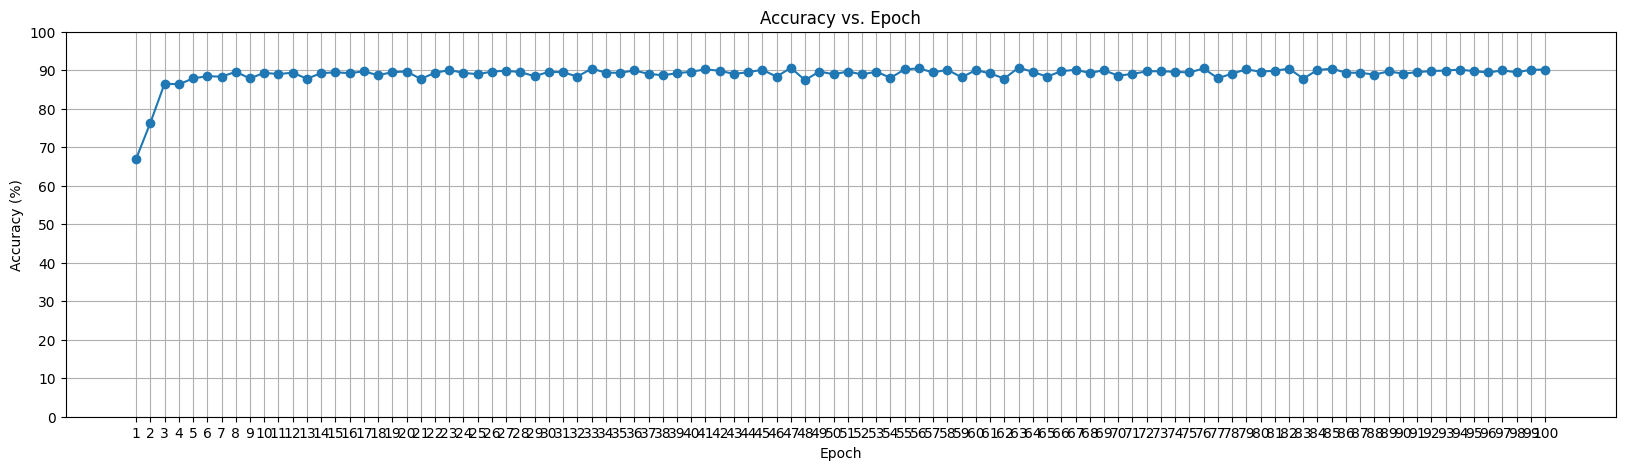

Epoch 1: Accuracy: 88.24510212588578%
Epoch 2: Accuracy: 88.03668195081283%
Epoch 3: Accuracy: 88.28678616090038%
Epoch 4: Accuracy: 88.24510212588578%
Epoch 5: Accuracy: 88.24510212588578%
Epoch 6: Accuracy: 88.37015423092956%
Epoch 7: Accuracy: 88.28678616090038%
Epoch 8: Accuracy: 88.32847019591496%
Epoch 9: Accuracy: 88.12005002084202%
Epoch 10: Accuracy: 88.28678616090038%
Epoch 11: Accuracy: 87.82826177573989%
Epoch 12: Accuracy: 88.28678616090038%
Epoch 13: Accuracy: 87.95331388078365%
Epoch 14: Accuracy: 87.49478949562318%
Epoch 15: Accuracy: 87.70320967069613%
Epoch 16: Accuracy: 88.37015423092956%
Epoch 17: Accuracy: 87.91162984576907%
Epoch 18: Accuracy: 86.07753230512714%
Epoch 19: Accuracy: 87.0362651104627%
Epoch 20: Accuracy: 86.78616090037515%
Epoch 21: Accuracy: 87.411421425594%
Epoch 22: Accuracy: 87.45310546060858%
Epoch 23: Accuracy: 88.2034180908712%
Epoch 24: Accuracy: 87.11963318049187%
Epoch 25: Accuracy: 88.45352230095874%
Epoch 26: Accuracy: 88.24510212588578%

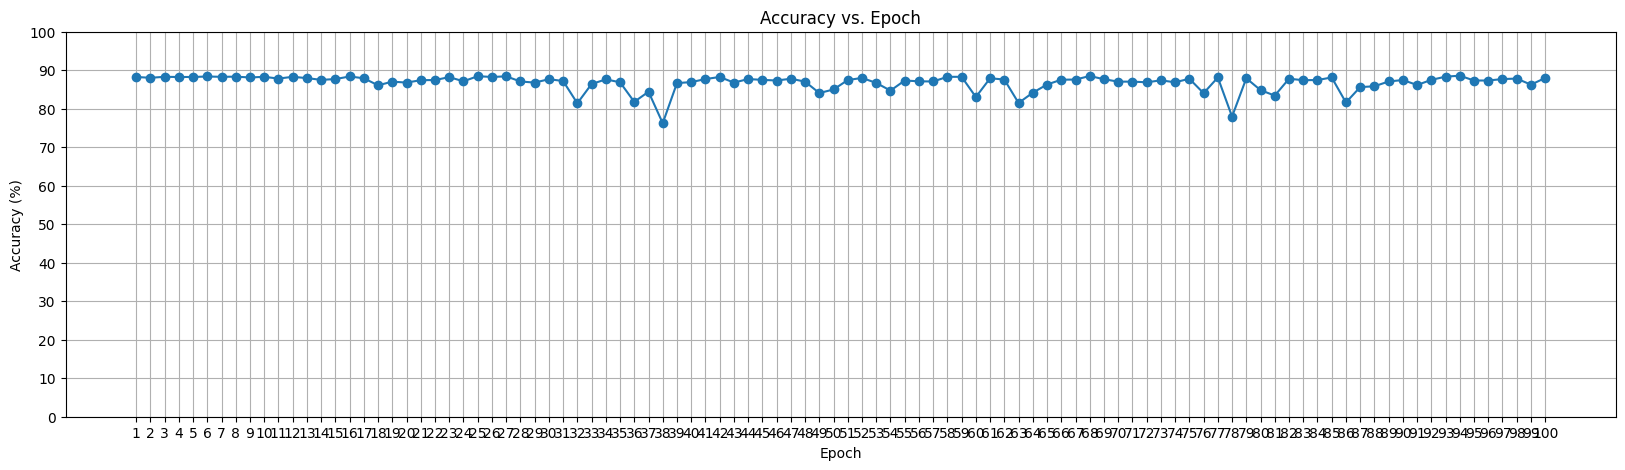

Epoch 1: Accuracy: 83.53480616923719%
Epoch 2: Accuracy: 83.53480616923719%
Epoch 3: Accuracy: 84.70195914964569%
Epoch 4: Accuracy: 88.28678616090038%
Epoch 5: Accuracy: 85.53563984993747%
Epoch 6: Accuracy: 86.91121300541893%
Epoch 7: Accuracy: 89.32888703626512%
Epoch 8: Accuracy: 88.99541475614839%
Epoch 9: Accuracy: 89.745727386411%
Epoch 10: Accuracy: 89.32888703626512%
Epoch 11: Accuracy: 80.61692371821593%
Epoch 12: Accuracy: 89.20383493122134%
Epoch 13: Accuracy: 87.7865777407253%
Epoch 14: Accuracy: 89.4122551062943%
Epoch 15: Accuracy: 88.49520633597332%
Epoch 16: Accuracy: 88.78699458107545%
Epoch 17: Accuracy: 88.87036265110463%
Epoch 18: Accuracy: 89.3705710712797%
Epoch 19: Accuracy: 86.28595248020008%
Epoch 20: Accuracy: 90.03751563151313%
Epoch 21: Accuracy: 83.24301792413506%
Epoch 22: Accuracy: 90.5377240516882%
Epoch 23: Accuracy: 90.1625677365569%
Epoch 24: Accuracy: 85.66069195498125%
Epoch 25: Accuracy: 90.91288036681951%
Epoch 26: Accuracy: 88.62025844101709%
Ep

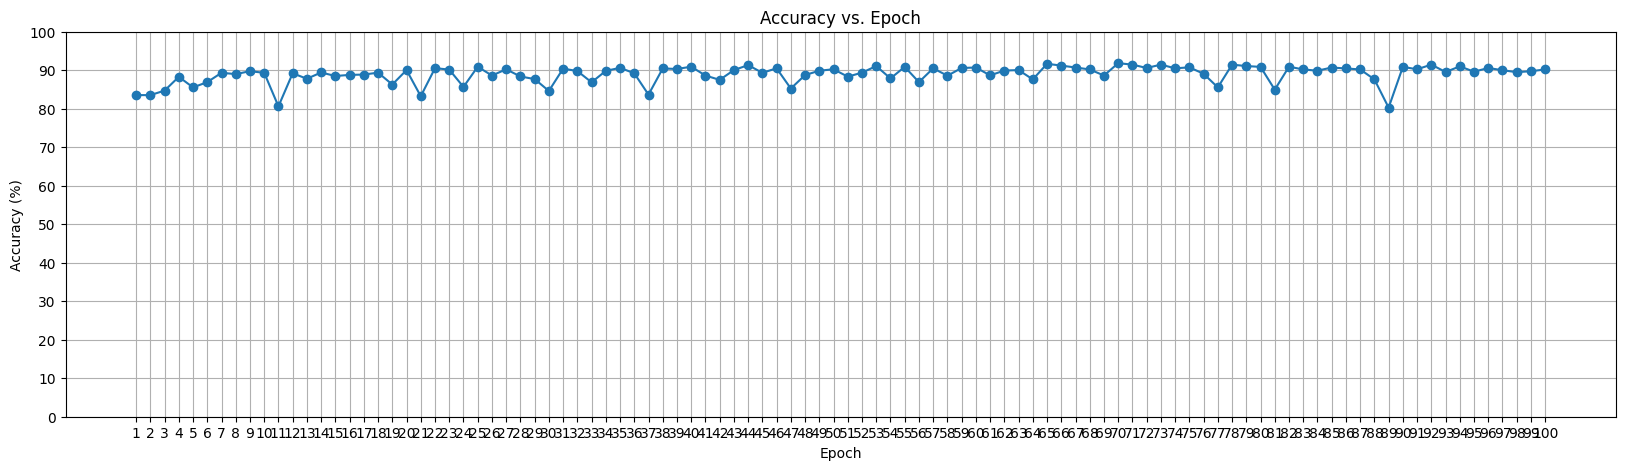

Epoch 1: Accuracy: 76.28178407669863%
Epoch 2: Accuracy: 87.66152563568153%
Epoch 3: Accuracy: 84.74364318466027%
Epoch 4: Accuracy: 88.5785744060025%
Epoch 5: Accuracy: 88.5368903709879%
Epoch 6: Accuracy: 88.95373072113381%
Epoch 7: Accuracy: 88.82867861609003%
Epoch 8: Accuracy: 88.87036265110463%
Epoch 9: Accuracy: 88.5785744060025%
Epoch 10: Accuracy: 88.66194247603168%
Epoch 11: Accuracy: 88.32847019591496%
Epoch 12: Accuracy: 88.62025844101709%
Epoch 13: Accuracy: 88.41183826594414%
Epoch 14: Accuracy: 88.49520633597332%
Epoch 15: Accuracy: 87.95331388078365%
Epoch 16: Accuracy: 84.61859107961651%
Epoch 17: Accuracy: 88.41183826594414%
Epoch 18: Accuracy: 88.5785744060025%
Epoch 19: Accuracy: 87.82826177573989%
Epoch 20: Accuracy: 88.49520633597332%
Epoch 21: Accuracy: 88.24510212588578%
Epoch 22: Accuracy: 88.45352230095874%
Epoch 23: Accuracy: 88.32847019591496%
Epoch 24: Accuracy: 88.37015423092956%
Epoch 25: Accuracy: 88.87036265110463%
Epoch 26: Accuracy: 87.86994581075449%

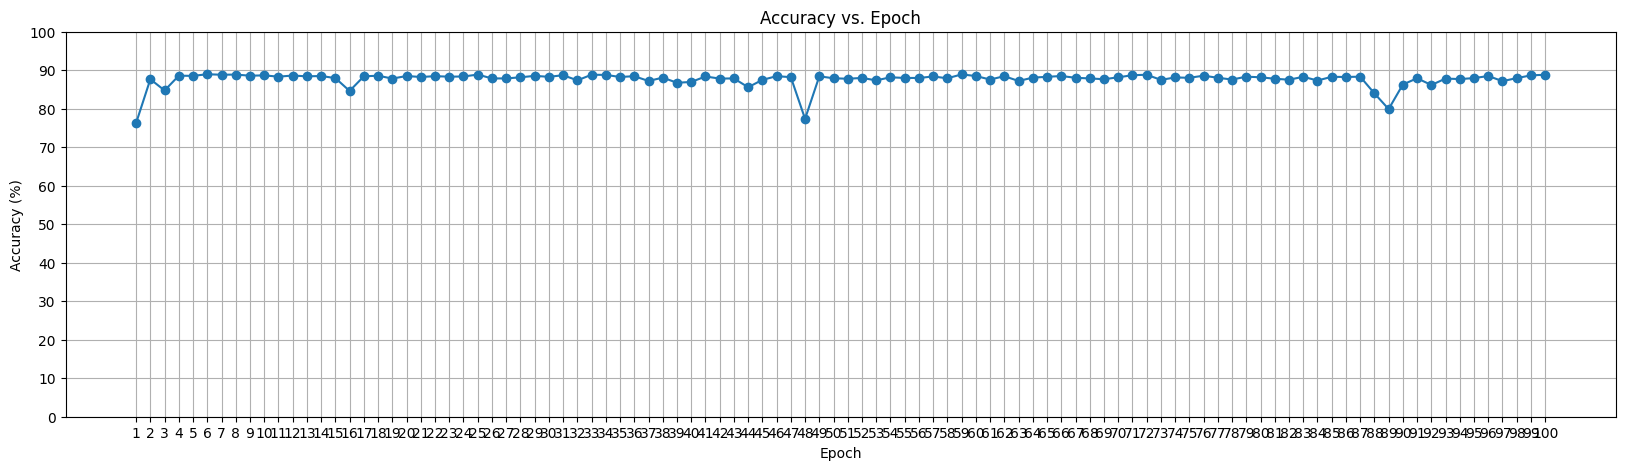

Epoch 1: Accuracy: 85.4105877448937%
Epoch 2: Accuracy: 87.411421425594%
Epoch 3: Accuracy: 88.82867861609003%
Epoch 4: Accuracy: 89.03709879116299%
Epoch 5: Accuracy: 90.32930387661526%
Epoch 6: Accuracy: 91.07961650687787%
Epoch 7: Accuracy: 88.78699458107545%
Epoch 8: Accuracy: 90.87119633180492%
Epoch 9: Accuracy: 90.78782826177574%
Epoch 10: Accuracy: 88.45352230095874%
Epoch 11: Accuracy: 90.37098791162984%
Epoch 12: Accuracy: 91.28803668195081%
Epoch 13: Accuracy: 89.95414756148395%
Epoch 14: Accuracy: 89.91246352646937%
Epoch 15: Accuracy: 89.95414756148395%
Epoch 16: Accuracy: 90.91288036681951%
Epoch 17: Accuracy: 89.91246352646937%
Epoch 18: Accuracy: 90.5794080867028%
Epoch 19: Accuracy: 90.41267194664444%
Epoch 20: Accuracy: 90.95456440183409%
Epoch 21: Accuracy: 90.5377240516882%
Epoch 22: Accuracy: 90.28761984160067%
Epoch 23: Accuracy: 88.91204668611921%
Epoch 24: Accuracy: 91.16298457690705%
Epoch 25: Accuracy: 90.74614422676115%
Epoch 26: Accuracy: 89.70404335139642%


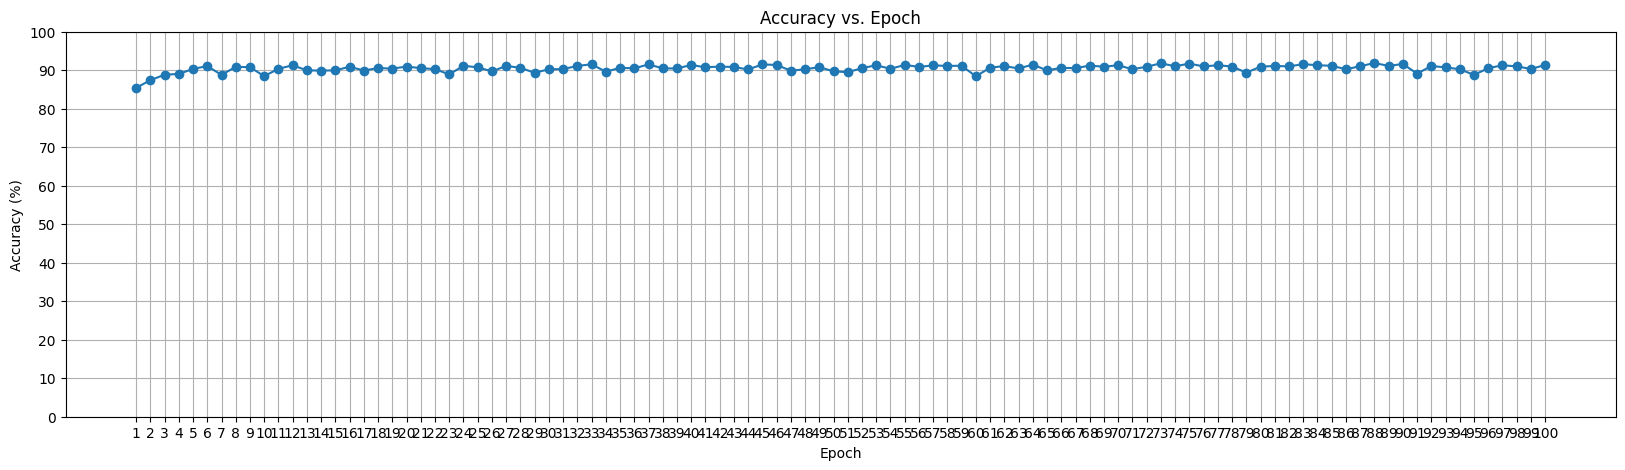

Epoch 1: Accuracy: 86.32763651521468%
Epoch 2: Accuracy: 87.16131721550646%
Epoch 3: Accuracy: 87.61984160066694%
Epoch 4: Accuracy: 88.07836598582743%
Epoch 5: Accuracy: 87.7865777407253%
Epoch 6: Accuracy: 89.03709879116299%
Epoch 7: Accuracy: 88.16173405585661%
Epoch 8: Accuracy: 88.62025844101709%
Epoch 9: Accuracy: 89.16215089620675%
Epoch 10: Accuracy: 88.16173405585661%
Epoch 11: Accuracy: 89.32888703626512%
Epoch 12: Accuracy: 88.66194247603168%
Epoch 13: Accuracy: 89.4122551062943%
Epoch 14: Accuracy: 88.5785744060025%
Epoch 15: Accuracy: 89.62067528136724%
Epoch 16: Accuracy: 87.57815756565236%
Epoch 17: Accuracy: 89.16215089620675%
Epoch 18: Accuracy: 85.20216756982076%
Epoch 19: Accuracy: 89.99583159649855%
Epoch 20: Accuracy: 89.95414756148395%
Epoch 21: Accuracy: 87.11963318049187%
Epoch 22: Accuracy: 89.87077949145477%
Epoch 23: Accuracy: 89.32888703626512%
Epoch 24: Accuracy: 90.1625677365569%
Epoch 25: Accuracy: 89.82909545644019%
Epoch 26: Accuracy: 85.61900791996665%

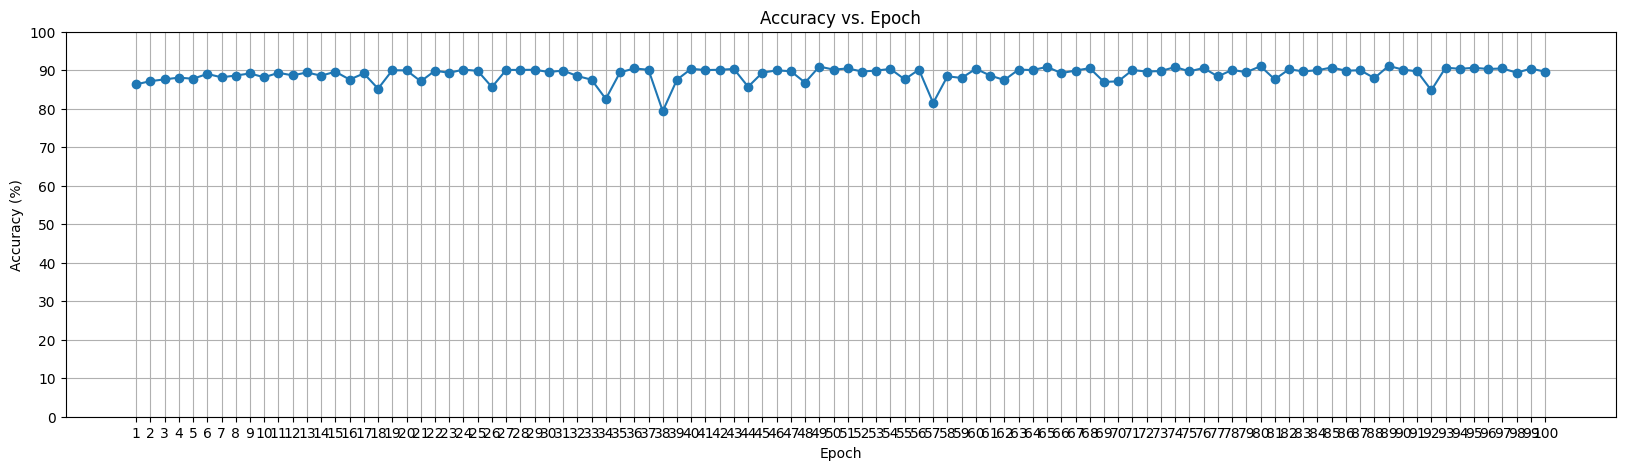

Epoch 1: Accuracy: 80.40850354314297%
Epoch 2: Accuracy: 84.2434347644852%
Epoch 3: Accuracy: 82.61775739891621%
Epoch 4: Accuracy: 87.07794914547728%
Epoch 5: Accuracy: 87.74489370571071%
Epoch 6: Accuracy: 88.16173405585661%
Epoch 7: Accuracy: 88.70362651104627%
Epoch 8: Accuracy: 86.74447686536057%
Epoch 9: Accuracy: 88.16173405585661%
Epoch 10: Accuracy: 88.12005002084202%
Epoch 11: Accuracy: 88.87036265110463%
Epoch 12: Accuracy: 86.99458107544811%
Epoch 13: Accuracy: 88.16173405585661%
Epoch 14: Accuracy: 88.82867861609003%
Epoch 15: Accuracy: 87.86994581075449%
Epoch 16: Accuracy: 87.3697373905794%
Epoch 17: Accuracy: 87.7865777407253%
Epoch 18: Accuracy: 87.11963318049187%
Epoch 19: Accuracy: 88.5368903709879%
Epoch 20: Accuracy: 87.91162984576907%
Epoch 21: Accuracy: 88.16173405585661%
Epoch 22: Accuracy: 88.99541475614839%
Epoch 23: Accuracy: 86.6194247603168%
Epoch 24: Accuracy: 88.32847019591496%
Epoch 25: Accuracy: 87.3697373905794%
Epoch 26: Accuracy: 87.86994581075449%
E

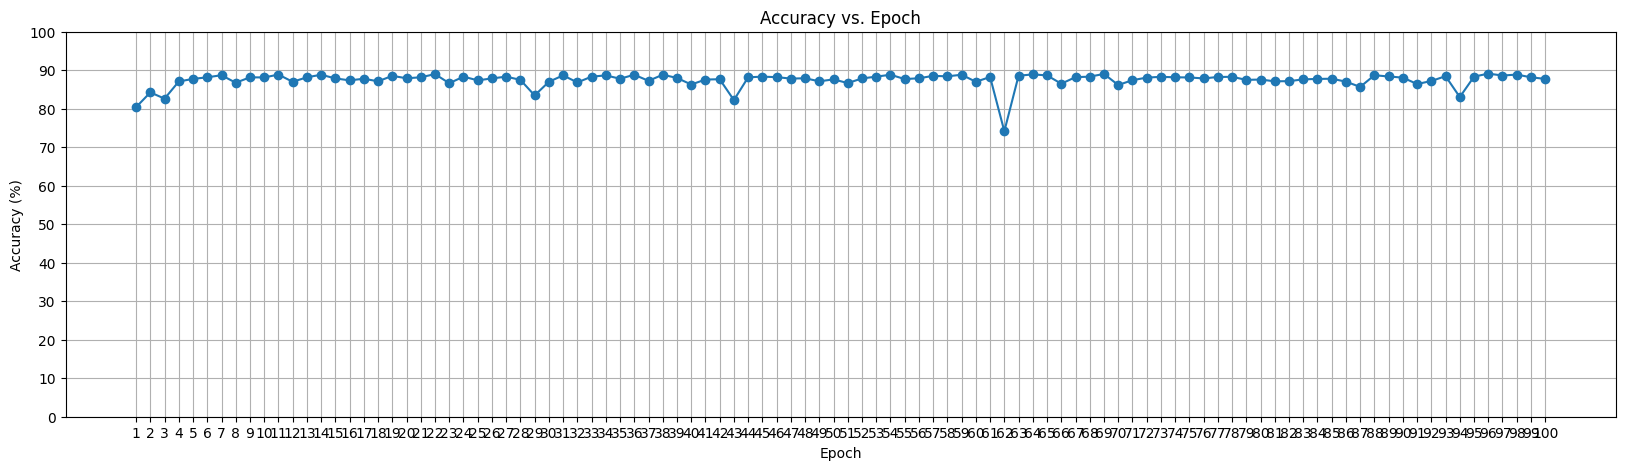

Epoch 1: Accuracy: 72.15506461025427%
Epoch 2: Accuracy: 86.11921634014172%
Epoch 3: Accuracy: 87.70320967069613%
Epoch 4: Accuracy: 89.03709879116299%
Epoch 5: Accuracy: 89.24551896623593%
Epoch 6: Accuracy: 87.91162984576907%
Epoch 7: Accuracy: 88.32847019591496%
Epoch 8: Accuracy: 89.28720300125052%
Epoch 9: Accuracy: 88.78699458107545%
Epoch 10: Accuracy: 87.66152563568153%
Epoch 11: Accuracy: 87.91162984576907%
Epoch 12: Accuracy: 88.99541475614839%
Epoch 13: Accuracy: 88.78699458107545%
Epoch 14: Accuracy: 88.91204668611921%
Epoch 15: Accuracy: 88.28678616090038%
Epoch 16: Accuracy: 89.12046686119217%
Epoch 17: Accuracy: 88.82867861609003%
Epoch 18: Accuracy: 88.91204668611921%
Epoch 19: Accuracy: 89.57899124635264%
Epoch 20: Accuracy: 87.99499791579825%
Epoch 21: Accuracy: 88.37015423092956%
Epoch 22: Accuracy: 85.91079616506877%
Epoch 23: Accuracy: 88.28678616090038%
Epoch 24: Accuracy: 88.95373072113381%
Epoch 25: Accuracy: 87.99499791579825%
Epoch 26: Accuracy: 87.95331388078

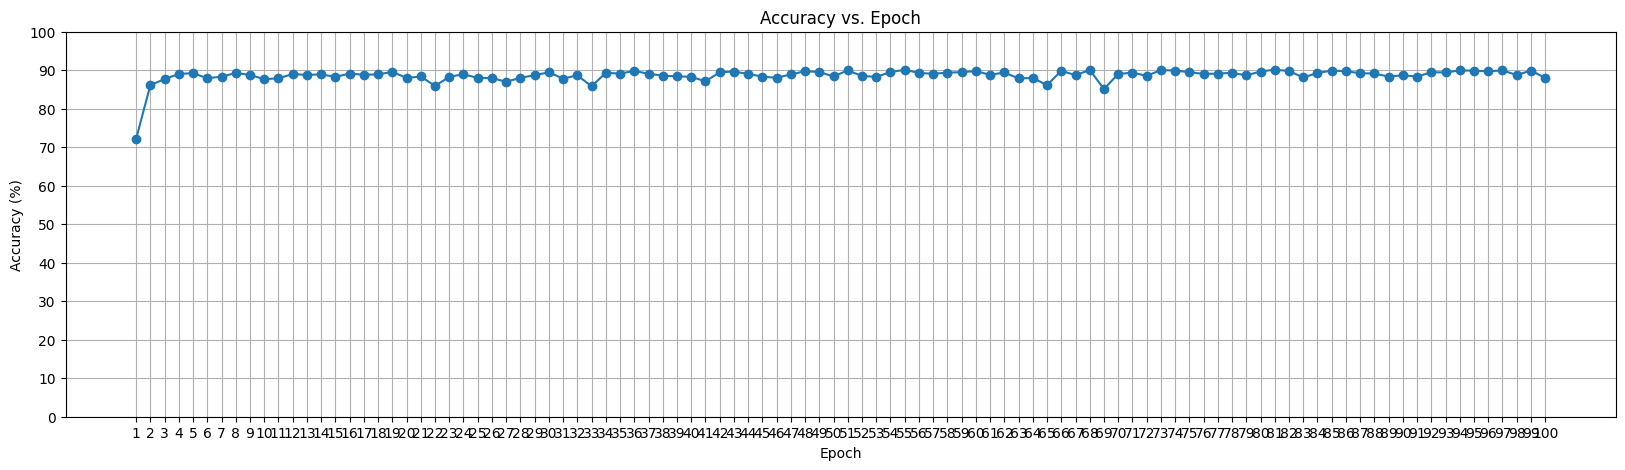

In [29]:
models = {}
for genre in genres:
    y_genre = (data_df['genre'] == genre).astype(int).values  # Create binary labels for this genre
    model = MLP(input_dim=X.shape[1], output_dim=8)  # Output dim is 1 for binary classification
    model.to(device)
    train_loader, test_loader = create_loaders(X, y_genre)  # Use the correct labels here
    
    accuracy = train_model(model, train_loader, test_loader, device)
    models[genre] = model


In [118]:
def multi_label_soft_voting_ensemble(models, X, device, threshold=0.5):
    num_samples = X.shape[0]
    num_classes = 8  # Assuming 8 genres
    total_probs = torch.zeros((num_samples, num_classes), device=device)

    # Aggregate probabilities from each model
    for model in models.values():
        model.eval()
        with torch.no_grad():
            outputs = model(X)  # Get logits from model
            probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            total_probs += probabilities / len(models)  # Average probabilities

    # Apply threshold to determine class membership
    predicted_classes = (total_probs >= threshold).long()  # Convert boolean to long for class indices
    return predicted_classes

In [119]:

X_scaled =StandardScaler().fit_transform(data_df.drop('genre', axis=1))
# Example usage
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
predicted_classes = multi_label_soft_voting_ensemble(models, X_tensor, device, threshold=0.5)
predicted_classes = predicted_classes.cpu().numpy()

# Mapping indices back to genre names for interpretation
genre_names = data_df['genre'].unique()
predicted_genres = [[genre_names[j] for j in range(8) if predicted_classes[i, j] == 1] for i in range(len(predicted_classes))]


In [120]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

# You need true binary labels for all genres for each sample
true_labels = pd.get_dummies(data_df['genre']).values  # Convert genres to one-hot encoding

# Evaluate multi-label classification
hammingloss = hamming_loss(true_labels, predicted_classes)
print("Hamming Loss:", hammingloss)  # Lower is better
print(classification_report(true_labels, predicted_classes, target_names=genre_names))


Hamming Loss: 0.21875781836377284
               precision    recall  f1-score   support

      Hip-Hop       0.12      1.00      0.22       999
          Pop       0.00      0.00      0.00       999
         Folk       0.00      0.00      0.00      1000
 Experimental       0.00      0.00      0.00       997
         Rock       0.00      0.00      0.00      1000
International       0.00      0.00      0.00      1000
   Electronic       0.00      0.00      0.00      1000
 Instrumental       0.00      0.00      0.00       999

    micro avg       0.12      0.12      0.12      7994
    macro avg       0.02      0.12      0.03      7994
 weighted avg       0.02      0.12      0.03      7994
  samples avg       0.12      0.12      0.12      7994



c:\Users\divya\OneDrive\Documents\UTAUSTIN\Semester6\460j\460jFinalProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
